In [1]:
import os, sys
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from shutil import copyfile
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams["figure.figsize"] = (20,3)

np.random.seed(42)
tf.random.set_seed(42)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices([physical_devices[0]], 'GPU')

In [2]:
historic_data_in_minibatch = 250

# Description
This notebook is used for comparing probability trehold change for predictions quality for already trained models. Just specify which model (directory name with 'trained_model' named model inside) you want to use in model_name variable below.

In [5]:
model_name = 'przebieg_2021_06_08-01_09_09'

# Data lodading

In [3]:
X_test, y_test, mean_features_test = (
    np.load('./data/X_test_shuffled_crypto_with_mean_model.npz'), 
    np.load('./data/y_test_shuffled_crypto_with_mean_model.npz'), 
    np.load('./data/mean_features_test_shuffled_crypto_with_mean_model.npz'))
X_test, y_test, mean_features_test = X_test['arr_0'], y_test['arr_0'], mean_features_test['arr_0']

In [4]:
y_test_org = np.copy(y_test)

# Data standarization

In [6]:
from pickle import load

X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1])

scaler = load(open(f'./{model_name}/input_scaler_with_ema_shuffled_crypto.pkl', 'rb'))
X_test = scaler.transform(X_test)

X_test = X_test.reshape((X_test.shape[0]), X_test.shape[1], 1)

# y categorization

In [7]:
one_ids = np.where(y_test >= 0.9)
zero_ids = np.where(y_test < 0.9)

y_test[one_ids[0], one_ids[1]] = 1
y_test[zero_ids[0], zero_ids[1]] = 0

ones, zeroes = len(one_ids[0]), len(zero_ids[0])
print(f'Positive %: {ones / (ones + zeroes)}')
print(f'Negative %: {1 - (ones / (ones + zeroes))}')

y_test = y_test.astype(np.int)

Positive %: 0.047182628737793414
Negative %: 0.9528173712622066


# Split for two model inputs

In [8]:
X_test_CNN, X_test_Dense = X_test[:, :historic_data_in_minibatch, :], X_test[:, historic_data_in_minibatch:, :] 

# Model loading

In [9]:
model = tf.keras.models.load_model(f'./{model_name}/trained_model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 1)]     0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 250, 1)       4           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 250, 128)     5248        batch_normalization[0][0]        
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 125, 128)     0           conv1d[0][0]                     
______________________________________________________________________________________________

In [10]:
model.evaluate((X_test_CNN, X_test_Dense), y_test, return_dict=True)

5153/5153 [==============================] - 106s 21ms/step - loss: 0.4761 - tp: 1746.0000 - fp: 6629.0000 - tn: 150462.0000 - fn: 6033.0000 - binary_accuracy: 0.9232 - precision: 0.2085 - recall: 0.2245 - auc: 0.5911 - prc: 0.0977


{'loss': 0.47605234384536743,
 'tp': 1746.0,
 'fp': 6629.0,
 'tn': 150462.0,
 'fn': 6033.0,
 'binary_accuracy': 0.9232000708580017,
 'precision': 0.20847761631011963,
 'recall': 0.22445043921470642,
 'auc': 0.5911259651184082,
 'prc': 0.09770732372999191}

# Predictions

In [14]:
y_test_pred = model.predict((X_test_CNN, X_test_Dense))
print(f'\n\nPredicted min, max range: {np.min(y_test_pred), np.max(y_test_pred)}\n')



Predicted min, max range: (8.512335e-14, 0.9999441)



In [15]:
_pred_one = np.where(y_test_pred >= 0.9)
_pred_zero = np.where(y_test_pred < 0.9)

y_test_pred[_pred_one] = 1.0
y_test_pred[_pred_zero] = 0.0

# Histogram

In [16]:
ids = np.where(y_test_pred == 1)[0]
# ids

In [17]:
y_test_org[ids].shape

(8375, 1)

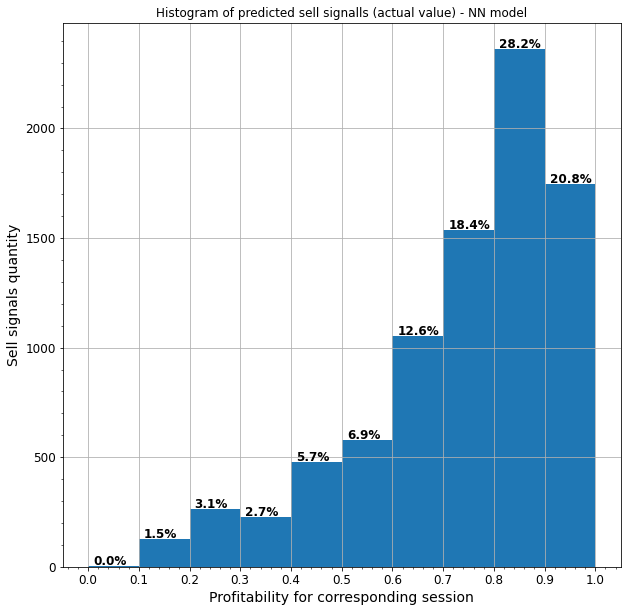

In [18]:
plt.figure(figsize=(10,10))
n, bins, _ = plt.hist(y_test_org[ids], bins=10, range=(0, 1), histtype='bar')
plt.title('Histogram of predicted sell signalls (actual value) - NN model')
plt.xlabel('Profitability for corresponding session')
plt.ylabel('Sell signals quantity')
plt.xticks(np.arange(0,1.1,0.1))
# plt.yticks(np.arange(0, 580, 40))
plt.minorticks_on()
total_samples = len(y_test_org[ids])
for samples_qty, rectangle in zip(n, _):
    xy = (rectangle.xy[0] + 0.01, rectangle.get_height() + 5)
    perc = round((samples_qty/total_samples) * 100, 1)
    plt.annotate(f'{perc}%', xy, fontweight='bold', size='large')
plt.grid()
plt.show()

# Treshold tuning

========= Treshold: 0.1 =========
total: 164870
[[0.51620064 0.43661673]
 [0.00793352 0.03924911]]
Statistics so far:
   Min  Max      Mean    Median  Range  Standard deviation  Treshold value
0  0.0  1.0  0.599648  0.637528    1.0            0.238955             0.1
========= Treshold: 0.1 finished!
========= Treshold: 0.2 =========
total: 164870
[[0.60700552 0.34581185]
 [0.0120034  0.03517923]]
Statistics so far:
   Min  Max      Mean    Median  Range  Standard deviation  Treshold value
0  0.0  1.0  0.599648  0.637528    1.0            0.238955             0.1
1  0.0  1.0  0.612181  0.654930    1.0            0.238520             0.2
========= Treshold: 0.2 finished!
========= Treshold: 0.3 =========
total: 164870
[[0.66900588 0.28381149]
 [0.01524231 0.03194032]]
Statistics so far:
   Min  Max      Mean    Median  Range  Standard deviation  Treshold value
0  0.0  1.0  0.599648  0.637528    1.0            0.238955             0.1
1  0.0  1.0  0.612181  0.654930    1.0            0.2

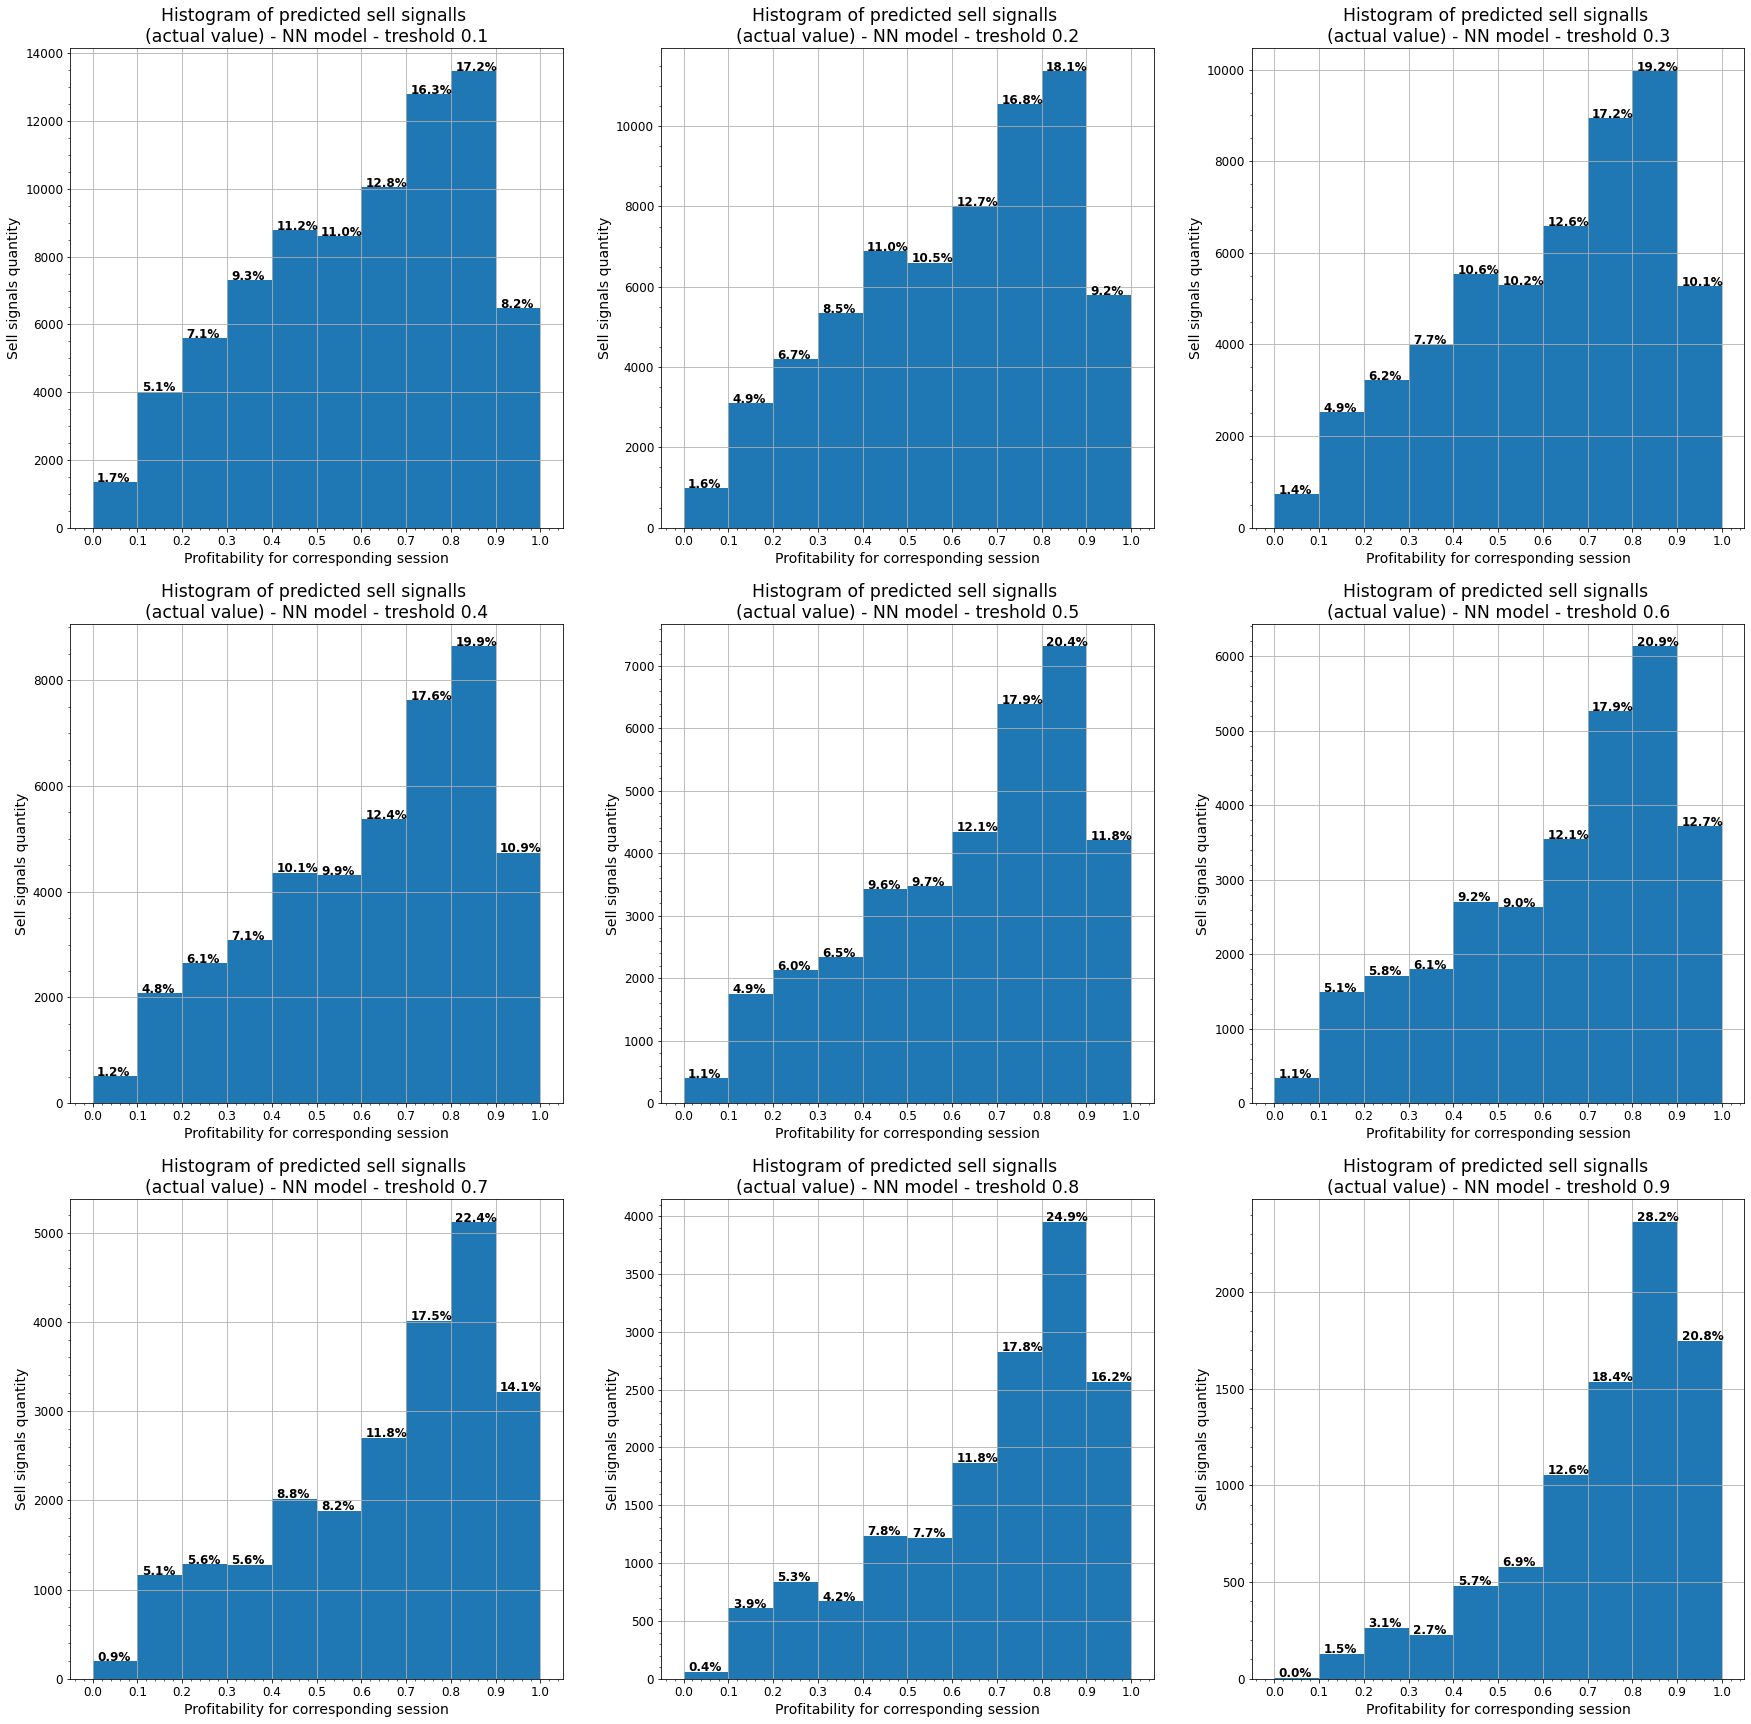

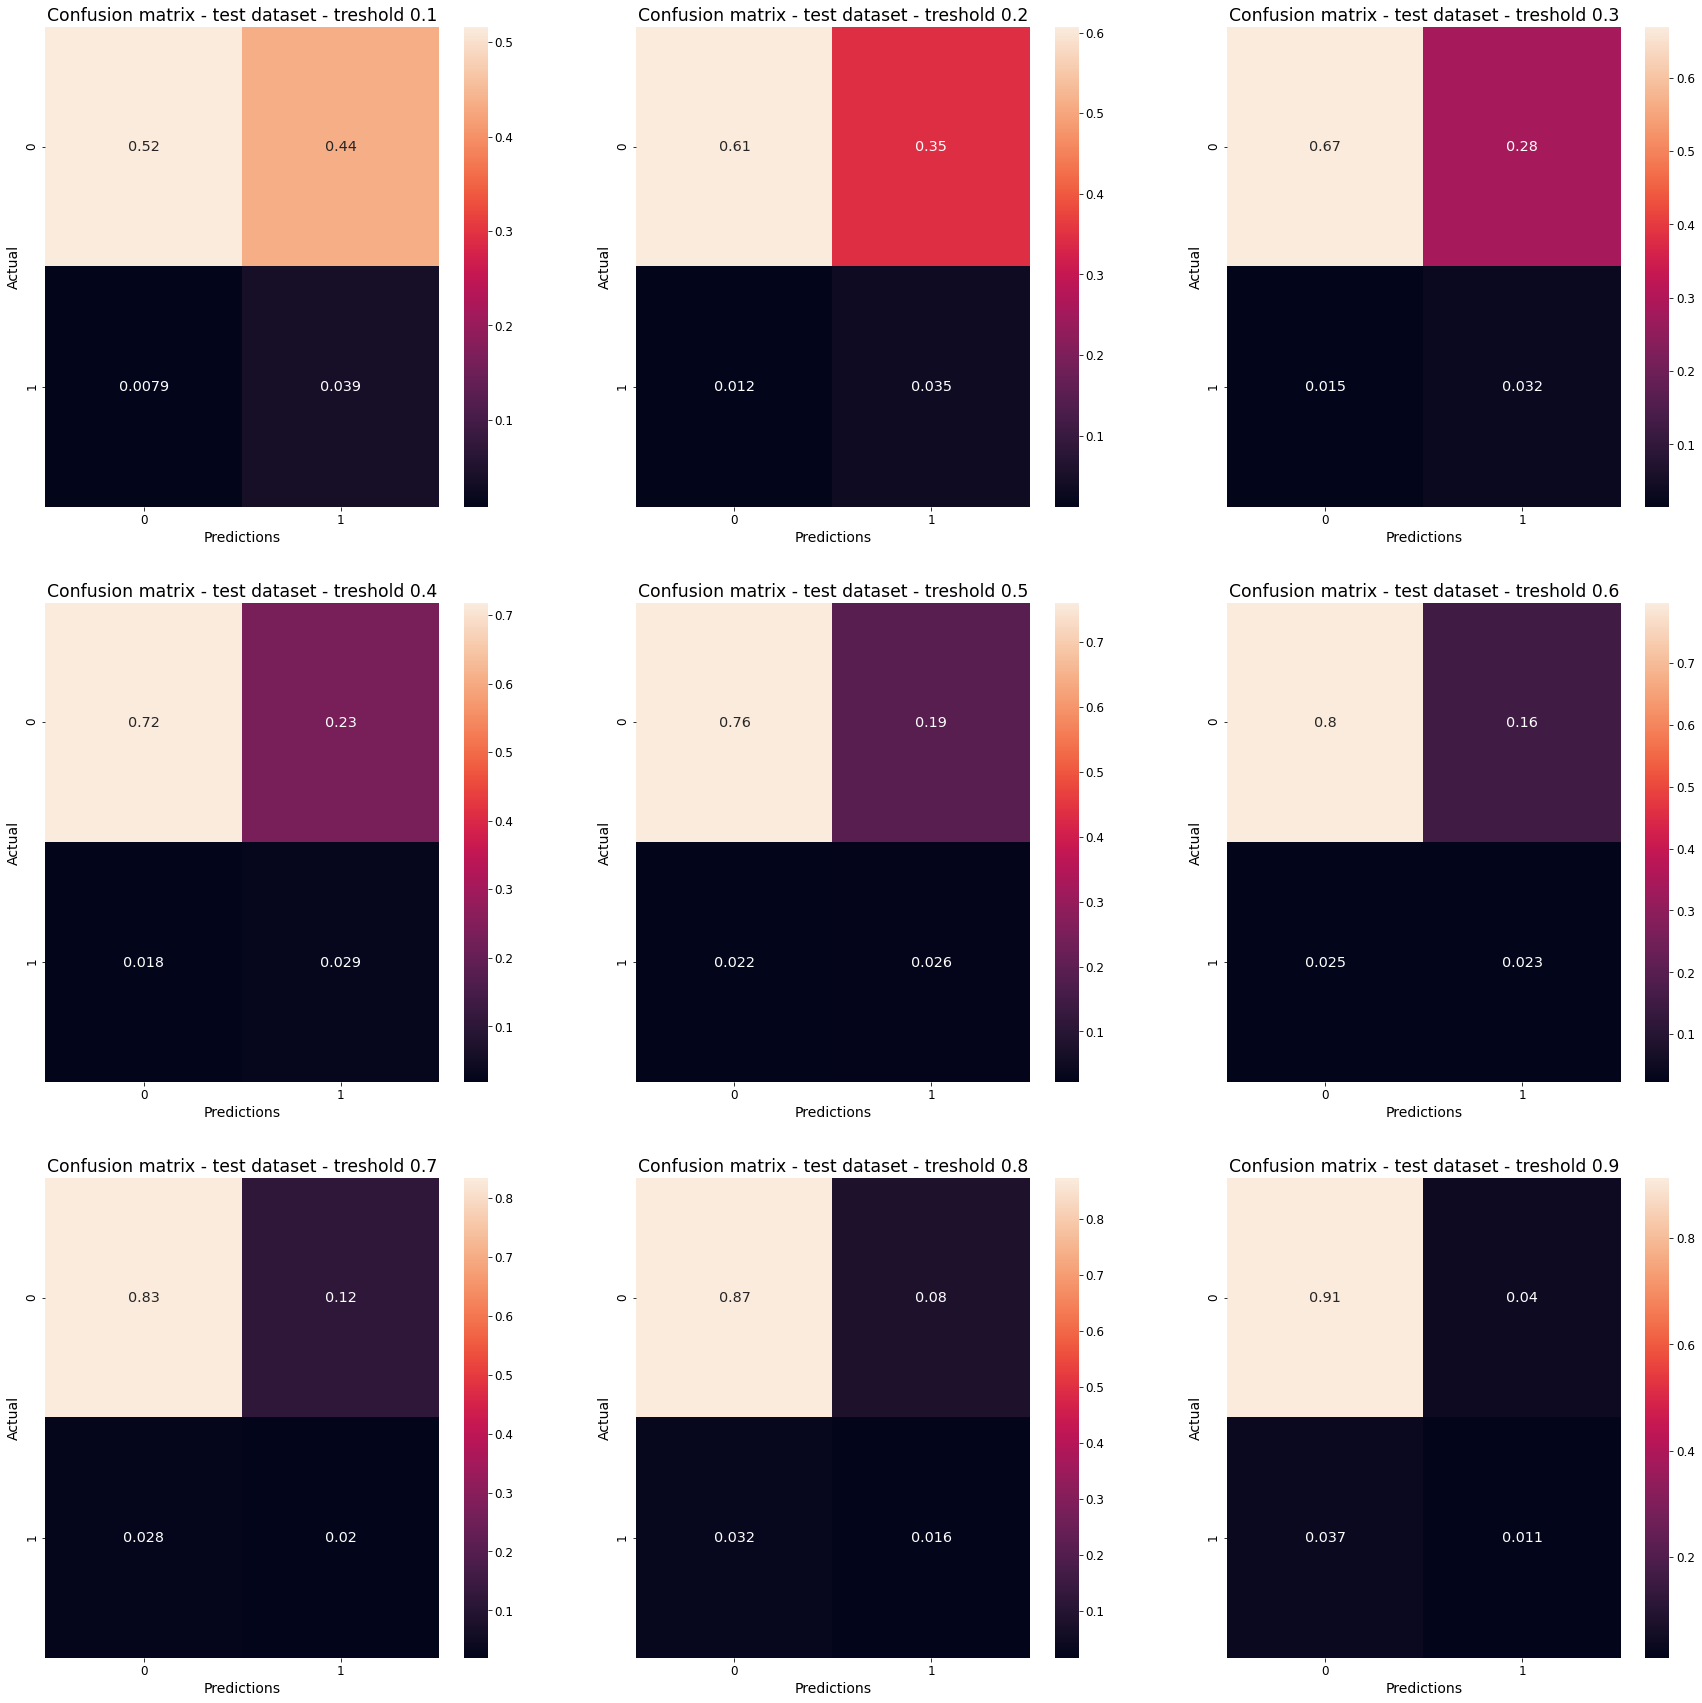

In [16]:
rows, cols = 3, 3

fig_hist, axs_hist = plt.subplots(rows, cols, figsize=(30,30))
fig_conf_matrix, axs_conf_matrix = plt.subplots(rows, cols, figsize=(30,30))

tresholds = np.arange(0.1, 1.0, 0.1)
tresholds = tresholds.reshape((rows, cols))

statistics_df = pd.DataFrame(columns=["Min", "Max", "Mean", "Median", "Range", "Standard deviation", "Treshold value"])

for row in range(rows):
    for column in range(cols):
        treshold = tresholds[row][column]
        print(f'========= Treshold: {round(treshold, 2)} =========')

        _temp_y = np.copy(y_test_org)

        one_ids = np.where(_temp_y >= 0.9)
        zero_ids = np.where(_temp_y < 0.9)

        _temp_y[one_ids[0], one_ids[1]] = 1
        _temp_y[zero_ids[0], zero_ids[1]] = 0

        ones, zeroes = len(one_ids[0]), len(zero_ids[0])

        _temp_y = _temp_y.astype(np.int)

        _y_pred = model.predict((X_test_CNN, X_test_Dense))

        _pred_one = np.where(_y_pred >= treshold)
        _pred_zero = np.where(_y_pred < treshold)

        _y_pred[_pred_one] = 1.0
        _y_pred[_pred_zero] = 0.0
        
        cm = sklearn.metrics.confusion_matrix(_temp_y, _y_pred)
        print(f'total: {np.sum(cm)}')
        cm = cm / np.sum(cm)
        print(cm)
        sns.heatmap(cm, annot=True, ax=axs_conf_matrix[row][column], annot_kws = {'fontsize': 'x-large'})
        axs_conf_matrix[row][column].set_title(
            f'Confusion matrix - test dataset - treshold {round(treshold, 2)}', 
            {'fontsize': 'xx-large'}
        )
        axs_conf_matrix[row][column].set_xlabel('Predictions')
        axs_conf_matrix[row][column].set_ylabel('Actual')


        ids = np.where(_y_pred == 1)[0]
        predicted_y_test_org = y_test_org[ids]

        min, max, mean = np.min(predicted_y_test_org), np.max(predicted_y_test_org), np.mean(predicted_y_test_org)
        median, scores_range, std = np.median(predicted_y_test_org), max-min, np.std(predicted_y_test_org)

        statistics = {
            "Min": min,
            "Max": max,
            "Mean": mean,
            "Median": median,
            "Range": scores_range,
            "Standard deviation": std,
            "Treshold value": treshold,
        }

        statistics_df = statistics_df.append(statistics, ignore_index=True)
        print(f'Statistics so far:\n{statistics_df}')

        n, bins, _ = axs_hist[row][column].hist(predicted_y_test_org, bins=10, range=(0, 1), histtype='bar')
        axs_hist[row][column].set_title(
            f'Histogram of predicted sell signalls \n(actual value) - NN model - treshold {round(treshold, 2)}', 
            {'fontsize': 'xx-large'}
        )
        axs_hist[row][column].set_xlabel('Profitability for corresponding session')
        axs_hist[row][column].set_ylabel('Sell signals quantity')
        axs_hist[row][column].set_xticks(np.arange(0,1.1,0.1))
        axs_hist[row][column].grid()
        axs_hist[row][column].minorticks_on()
        total_samples = len(predicted_y_test_org)
        for samples_qty, rectangle in zip(n, _):
            xy = (rectangle.xy[0] + 0.01, rectangle.get_height() + 5)
            perc = round((samples_qty/total_samples) * 100, 1)
            axs_hist[row][column].annotate(f'{perc}%', xy, fontweight='bold', size='large')
        
        print(f'========= Treshold: {round(treshold, 2)} finished!')
        

In [17]:
statistics_df

,Min,Max,Mean,Median,Range,Standard deviation,Treshold value
0,0.000000,1.0,0.599648,0.637528,1.000000,0.238955,0.1
1,0.000000,1.0,0.612181,0.654930,1.000000,0.238520,0.2
2,0.000000,1.0,0.624262,0.672455,1.000000,0.237718,0.3
3,0.000000,1.0,0.633478,0.687365,1.000000,0.237272,0.4
4,0.000000,1.0,0.640767,0.700280,1.000000,0.237514,0.5
5,0.000000,1.0,0.646801,0.711891,1.000000,0.239239,0.6
6,0.007983,1.0,0.659224,0.731894,0.992017,0.238759,0.7
7,0.037231,1.0,0.687807,0.761543,0.962769,0.227746,0.8
8,0.080079,1.0,0.740448,0.796654,0.919921,0.194709,0.9


In [18]:
statistics_df.to_csv(f'./charts/statistics-by-tresholds-{model_name}.csv')

In [19]:
fig_hist.savefig(f'./charts/hist-diff-tresholds-{model_name}_3x3.png')
fig_conf_matrix.savefig(f'./charts/conf-matrix-diff-tresholds-{model_name}_3x3.png')